 # IEEE-CIS Fraud Detection

Vesta Corporation provided the dataset for this model. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually. 

Problem: Binary classification with a heavy dataset imbalance

## Objective: Detect fraud in Transactions

### Data:  
  
``isFraud`` is the binary that denotes whether a transaction is fraud or not and this is the dependent variable to be modeled for  

Data is broken into two files ***identity*** and ***transaction***, these can be join by the ``TransactioID``  
  
***Identity Categorical Features***
* DeviceType
* DeviceInfo
* id_12-id_38
  
***Transaction Categorical Features***
* Product CD
* emaildomain
* card1-card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1-M9

The ``TransactionDT`` feature is a timedelta from a given reference datetime (not an actual timestamp).


## Import Required Modules

In [110]:
import numpy as np
import pandas as pd
import gc
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report
from catboost.utils import get_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

In [90]:
# Functions

# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    
    # plot the no skill line
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the ro curve 
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def plot_confusion_matrix(cm, title, classes=['fraud', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    """Usage: plot_confusion_matrix(cm, title=string, save=boolean, saveas=string)"""
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

def plot_feature_importance(clf, training_set: pd.DataFrame):
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_, training_set.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:30])
    plt.title('XGB Most Important Features')
    plt.tight_layout()
    plt.show()

## Load the Dataset

In [3]:
FOLDER_PATH = 'data'
train_identity = pd.read_csv(f'{FOLDER_PATH}/train_identity.csv')
train_transaction = pd.read_csv(f'{FOLDER_PATH}/train_transaction.csv')
test_identity = pd.read_csv(f'{FOLDER_PATH}/test_identity.csv')
test_transaction = pd.read_csv(f'{FOLDER_PATH}/test_transaction.csv')

In [4]:
# merge the testing and training data
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [5]:
print(f'Transaction df shape: {train_transaction.shape}')
train_transaction.head()

Transaction df shape: (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(f'Identity df shape: {train_identity.shape}')
train_identity.head()

Identity df shape: (144233, 41)


,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [7]:
del train_identity, train_transaction, test_identity, test_transaction

## Exploratory Data Analysis

Click [here](https://github.com/JoshSpangler96/IEEE-CIS-Fraud-Detection/blob/main/IEEE_Fraud_Detection_EDA.ipynb) to view the EDA I performed for this dataset \
\
Key takeaways from EDA: 
* Highly imbalanced dataset with 3.5% fraud
* Train data and test data are seperated by time. Need time based split for validation set
* Ff the 415 features in the V, C, D, M, and ID categories there are 136 uncorrelated useful features
* Highest precentage of Fraud happens early morning

In [8]:
test.columns = test.columns.str.replace('[-]', '_')

In [9]:
# Keep only the useful columns from the EDA
features_to_use = [
    'TransactionID', 'TransactionDT', 'TransactionAmt', 
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'DeviceType', 
    'DeviceInfo', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 
    'V147', 'V142', 'V1', 'V174', 'V109', 'V201', 'V238', 'V271', 'V78', 
    'V160', 'V65', 'V339', 'V27', 'V138', 'V320', 'V6', 'V223', 'V114', 
    'V118', 'V173', 'V80', 'V107', 'V258', 'V44', 'V198', 'V252', 'V220', 
    'V309', 'V209', 'V67', 'V124', 'V260', 'V155', 'V176', 'V55', 'V36', 
    'V325', 'V127', 'V175', 'V82', 'V20', 'V329', 'V111', 'V139', 'V210', 
    'V30', 'V86', 'V3', 'V37', 'V13', 'V207', 'V286', 'V47', 'V162', 'V8', 
    'V62', 'V234', 'V56', 'V240', 'V23', 'V4', 'V115', 'V166', 'V121', 'V76', 
    'V259', 'V312', 'V120', 'V169', 'V305', 'V291', 'V185', 'V26', 'V241', 
    'V250', 'V108', 'V261', 'V54', 'D5', 'D14', 'D1', 'D9', 'D13', 'D8', 
    'D15', 'D10', 'C1', 'C5', 'C3', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 
    'M1', 'M3', 'M8', 'id_08', 'id_09', 'id_28', 'id_07', 'id_37', 'id_01', 
    'id_27', 'id_25', 'id_21', 'id_12', 'id_38', 'id_35', 'id_30', 'id_04', 
    'id_05', 'id_29', 'id_36', 'id_34', 'id_11', 'id_26', 'id_13', 'id_24', 
    'id_23', 'id_20', 'id_17', 'id_14', 'id_31', 'id_32', 'id_03', 'id_10', 
    'id_18', 'id_02', 'id_06', 'id_16', 'id_15', 'id_19', 'id_33', 'id_22']

#reduce both test and train
print(f'Datasets have {len(train.columns)} features before reduction')
train_features = features_to_use + ['isFraud']
train = train[train_features]
test = test[features_to_use]
print(f'Datasets have {len(train.columns)} features after reduction')

Datasets have 434 features before reduction
Datasets have 155 features after reduction


## Feature Engineering

In [10]:
START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")

# create a cents feature
datasets = [train, test]
for data in datasets:
    data['cents'] = (data['TransactionAmt'] - np.floor(data['TransactionAmt'])).astype('float32')
    data['log_TransactionAmt'] = np.log(data['TransactionAmt'])
    data[['P_email_1', 'P_email_2', 'P_email_3']] = data['P_emaildomain'].str.split('.', expand=True)
    data.drop('P_emaildomain', axis=1, inplace=True)
    data[['R_email_1', 'R_email_2', 'R_email_3']] = data['R_emaildomain'].str.split('.', expand=True)
    data.drop('R_emaildomain', axis=1, inplace=True)
    data['Date'] = data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
    data['Weekdays'] = data['Date'].dt.dayofweek
    data['Hours'] = data['Date'].dt.hour
    data['Days'] = data['Date'].dt.day
    
print(f'Datasets have {len(train.columns)} features after feature engineering')

Datasets have 165 features after feature engineering


## Prepare for Modeling

***Dropping Bad Columns***

In [11]:
# row_count = train.shape[0]
# row_count

In [12]:
# # get a list of columns with over 90% null values
# nan_col = [col for col in train.columns if (train[col].isnull().sum() / row_count) > 0.9]
# nan_col_test = [col for col in test.columns if (test[col].isnull().sum() / row_count) > 0.9]

# # get a list of columns that are dominated by one value
# vast_majority_col = [col for col in train.columns \
#                            if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
# vast_majority_col_test = [col for col in test.columns \
#                            if test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [13]:
# drop_cols = nan_col + nan_col_test + vast_majority_col + vast_majority_col_test
# drop_cols.remove('isFraud')

In [14]:
# print(f'Dropping {len(train_drop)} columns from the dataframe')

In [15]:
# train.drop(train_drop, axis=1, inplace=True)
# test.drop(test_drop, axis=1, inplace=True)

***Categorical Feature Encoding***

In [16]:
# get a list of all categorical features in the datasets
d_type = pd.DataFrame(train.dtypes)
d_type.rename({0: 'dtype'}, axis=1,  inplace=True)
d_type.reset_index(inplace=True)
d_type['dtype'] = d_type['dtype'].astype('string')
cat_col = d_type.loc[(d_type['dtype'] != 'int64') &\
                     (d_type['dtype'] != 'float64') &\
                     (d_type['dtype'] != 'datetime64[ns]')]['index'].to_list()

print(cat_col)

['ProductCD', 'card4', 'card6', 'DeviceType', 'DeviceInfo', 'M5', 'M7', 'M4', 'M2', 'M9', 'M6', 'M1', 'M3', 'M8', 'id_28', 'id_37', 'id_27', 'id_12', 'id_38', 'id_35', 'id_30', 'id_29', 'id_36', 'id_34', 'id_23', 'id_31', 'id_16', 'id_15', 'id_33', 'cents', 'P_email_1', 'P_email_2', 'P_email_3', 'R_email_1', 'R_email_2', 'R_email_3']


In [17]:
for i in range(len(cat_col)):
    if cat_col[i] in train.columns:
        le = LabelEncoder()
        le.fit(list(train[cat_col[i]].astype(str).values) + list(test[cat_col[i]].astype(str).values))
        train[cat_col[i]] = le.transform(list(train[cat_col[i]].astype(str).values))
        test[cat_col[i]] = le.transform(list(test[cat_col[i]].astype(str).values))   

***Clean Missing Values***

In [18]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
train.fillna(train.median(), inplace=True)
test.fillna(test.median(), inplace=True)

***Reduce Memory Usage***

In [76]:
# set up X train and y train
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID', 'Date'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']

In [77]:
# reduce the memory usage
X = reduce_mem_usage2(X)

Memory usage of dataframe is 648.79 MB
Memory usage after optimization is: 172.90 MB
Decreased by 73.4%


In [78]:
gc.collect()

188

### Resampling the Data

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [93]:
from imblearn.under_sampling import RandomUnderSampler

ran=RandomUnderSampler() ##intialize to return indices of dropped rows
X_rs, y_rs = ran.fit_resample(X_train, y_train)

In [94]:
# from imblearn.over_sampling import RandomOverSampler

# ran=RandomOverSampler()
# X_train_ran,y_train_ran= ran.fit_resample(X_train,y_train)

### Modeling

XGBOOST

In [104]:
# Parameter grid for XGBoost
params = {
        'min_child_weight': [0.5, 0.75, 1],
        'gamma': [0.25, 0.5, 1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'max_depth': [14, 16, 18]
        }
# fit model no training data

xgb_clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=200, 
    objective='binary:logistic',
    eval_metric='auc'
)

param_comb = 5

random_search = RandomizedSearchCV(xgb_clf, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=3)

random_search.fit(X_rs, y_rs, verbose=100)

print('\n Best hyperparameters:')
print(random_search.best_params_)
print('\n Best estimator:')
print(random_search.best_estimator_)

[15:21:39] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Best hyperparameters:
{'subsample': 1.0, 'min_child_weight': 0.5, 'max_depth': 18, 'gamma': 1, 'colsample_bytree': 0.7}

 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=18,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [106]:
# xgb_clf = xgb.XGBClassifier(
#     learning_rate=0.015,
#     n_estimators=2000,
#     max_depth = 16,
#     min_child_weight=1,
#     subsample=0.8,
#     objective='reg:logistic',
#     eval_metric='auc',
#     gamma=0.66,
#     reg_alpha=0.4
# )
xgb_clf = xgb.XGBClassifier(
    learning_rate=0.02, 
    n_estimators=1000, 
    objective='binary:logistic',
    eval_metric='auc',
    subsample=1.0, 
    min_child_weight=0.5, 
    max_depth=18, 
    gamma=1, 
    colsample_bytree=0.7
)

xgb_clf.fit(X_rs, y_rs, 
            eval_set=[(X_test, y_test)],
            verbose=100, early_stopping_rounds=100)

[0]	validation_0-auc:0.86911
[100]	validation_0-auc:0.93234
[200]	validation_0-auc:0.94165
[300]	validation_0-auc:0.94577
[400]	validation_0-auc:0.94788
[500]	validation_0-auc:0.94899
[600]	validation_0-auc:0.94992
[700]	validation_0-auc:0.95055
[800]	validation_0-auc:0.95102
[900]	validation_0-auc:0.95136
[999]	validation_0-auc:0.95154


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='auc',
              gamma=1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=18, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              validate_parameters=1, verbosity=None)

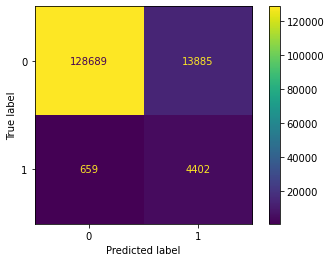

              precision    recall  f1-score   support

           0       0.99      0.90      0.95    142574
           1       0.24      0.87      0.38      5061

    accuracy                           0.90    147635
   macro avg       0.62      0.89      0.66    147635
weighted avg       0.97      0.90      0.93    147635



In [107]:
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

[0.         0.86978858 1.        ]
[0.         0.09738802 1.        ]
[2 1 0]
0.8333333333333333
Threshold value is: 1


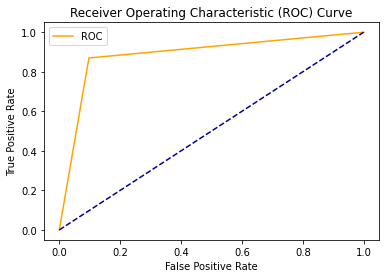

In [111]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

y_true = np.array([0,0, 1, 1,1])
y_scores = np.array([0.0,0.09, .05, .75,1])

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(tpr)
print(fpr)
print(thresholds)
print(roc_auc_score(y_true, y_scores))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

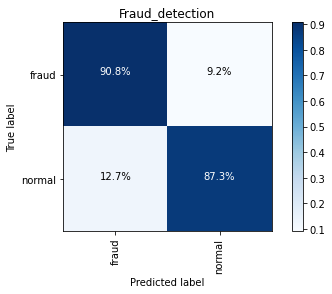

In [86]:
plot_confusion_matrix(cm, title='Fraud_detection')

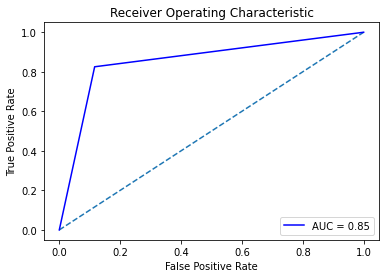

In [36]:
buildROC(y_test, y_pred)

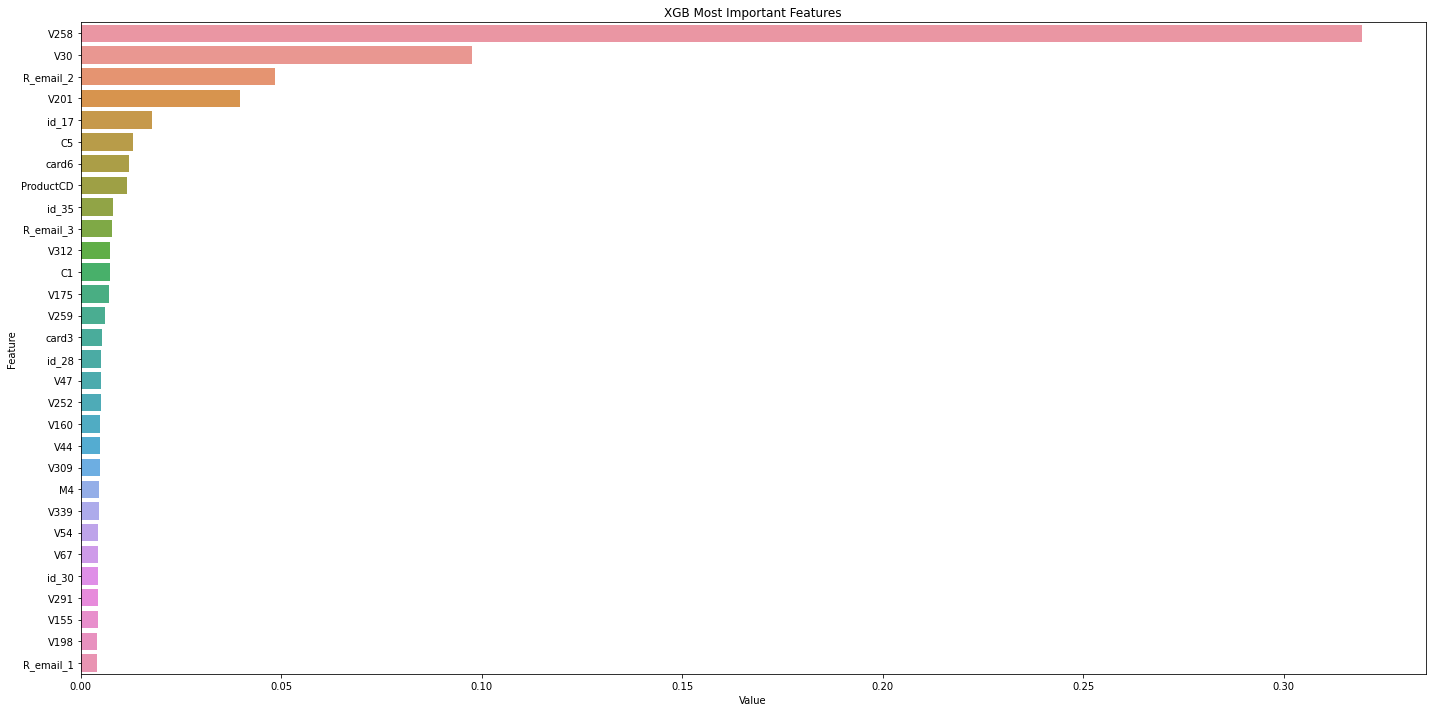

In [112]:
plot_feature_importance(clf=xgb_clf, training_set=X_train)

CAT BOOST

In [38]:
cb_params={
    'learning_rate':0.03,
    'iterations': 1000,
    'depth':13,
    'verbose':10
}

cb_clf = CatBoostClassifier(**cb_params)
cb_clf.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
)

0:	learn: 0.6415431	test: 0.6416203	test1: 0.6415686	best: 0.6415686 (0)	total: 2.18s	remaining: 36m 15s
10:	learn: 0.3237733	test: 0.3237839	test1: 0.3233041	best: 0.3233041 (10)	total: 22.6s	remaining: 33m 48s
20:	learn: 0.2007690	test: 0.2008487	test1: 0.2002652	best: 0.2002652 (20)	total: 45.3s	remaining: 35m 11s
30:	learn: 0.1492203	test: 0.1493110	test1: 0.1488524	best: 0.1488524 (30)	total: 1m 8s	remaining: 35m 45s
40:	learn: 0.1248859	test: 0.1249651	test1: 0.1247454	best: 0.1247454 (40)	total: 1m 29s	remaining: 34m 59s
50:	learn: 0.1127655	test: 0.1128328	test1: 0.1129488	best: 0.1129488 (50)	total: 1m 51s	remaining: 34m 42s
60:	learn: 0.1053964	test: 0.1054544	test1: 0.1059819	best: 0.1059819 (60)	total: 2m 12s	remaining: 34m 5s
70:	learn: 0.1003383	test: 0.1003892	test1: 0.1013876	best: 0.1013876 (70)	total: 2m 33s	remaining: 33m 31s
80:	learn: 0.0966284	test: 0.0966746	test1: 0.0981072	best: 0.0981072 (80)	total: 2m 54s	remaining: 33m 5s
90:	learn: 0.0938920	test: 0.0939348

750:	learn: 0.0473415	test: 0.0473656	test1: 0.0645665	best: 0.0645665 (750)	total: 26m 42s	remaining: 8m 51s
760:	learn: 0.0469942	test: 0.0470182	test1: 0.0643679	best: 0.0643679 (760)	total: 27m 3s	remaining: 8m 30s
770:	learn: 0.0465629	test: 0.0465868	test1: 0.0641510	best: 0.0641510 (770)	total: 27m 25s	remaining: 8m 8s
780:	learn: 0.0461325	test: 0.0461562	test1: 0.0638879	best: 0.0638879 (780)	total: 27m 46s	remaining: 7m 47s
790:	learn: 0.0458614	test: 0.0458851	test1: 0.0637523	best: 0.0637523 (790)	total: 28m 7s	remaining: 7m 25s
800:	learn: 0.0456343	test: 0.0456580	test1: 0.0636280	best: 0.0636280 (800)	total: 28m 29s	remaining: 7m 4s
810:	learn: 0.0453789	test: 0.0454025	test1: 0.0635287	best: 0.0635287 (810)	total: 28m 50s	remaining: 6m 43s
820:	learn: 0.0450322	test: 0.0450557	test1: 0.0633406	best: 0.0633406 (820)	total: 29m 12s	remaining: 6m 22s
830:	learn: 0.0447665	test: 0.0447898	test1: 0.0632133	best: 0.0632133 (830)	total: 29m 34s	remaining: 6m
840:	learn: 0.0444

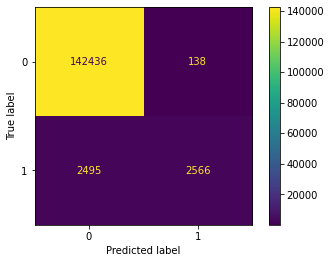

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    142574
           1       0.95      0.51      0.66      5061

    accuracy                           0.98    147635
   macro avg       0.97      0.75      0.83    147635
weighted avg       0.98      0.98      0.98    147635



In [39]:
y_pred = cb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cb_clf.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

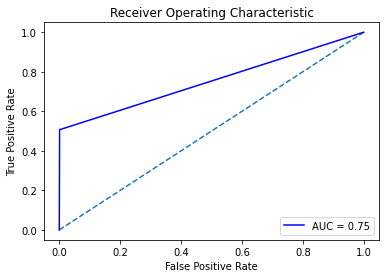

In [40]:
buildROC(y_test, y_pred)

Terrible Recall on this model. A Dummy variable that gueses no fraud every time would do just as well or even better

LGBM

In [57]:
parameters = {
    'num_leaves': 256,
    'objective': 'binary',
    'metric': 'auc',
#     'is_unbalance': 'true',
    'boosting': 'gbdt',
    'max_depth': 13,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.03,
    'verbose': 0,
    'n_estimators':5000
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMClassifier(**parameters, n_jobs = -1)
model.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_metric='auc',
    verbose=False
)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testi

LGBMClassifier(bagging_fraction=0.5, bagging_freq=20, boosting='gbdt',
               feature_fraction=0.5, learning_rate=0.03, max_depth=13,
               metric='auc', n_estimators=5000, num_leaves=256,
               objective='binary', verbose=0)

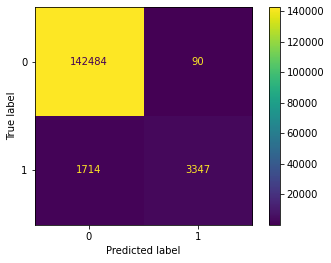

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    142574
           1       0.97      0.66      0.79      5061

    accuracy                           0.99    147635
   macro avg       0.98      0.83      0.89    147635
weighted avg       0.99      0.99      0.99    147635



In [58]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()
target_names = y.unique().tolist()
for i in range(len(target_names)):
    target_names[i] = str(target_names[i])
print(classification_report(y_test, y_pred, target_names=target_names))

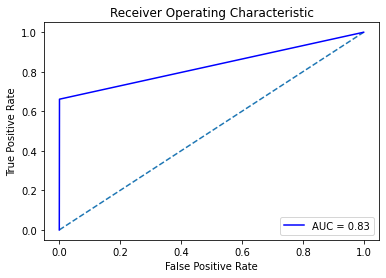

In [59]:
buildROC(y_test, y_pred)